# Importing Data and Packages #

In [2]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 9.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [59]:
pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 10.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE, RFECV

pd.set_option('display.max_columns', 50)

#defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'craig-shaffer-data-445-bucket'
bucket = s3.Bucket(bucket_name)

#defining the file to be read from s3 bucket
file_key = 'superstore_data.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

#reading the datafile
store = pd.read_csv(file_content_stream)
store.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0


**Imputing Missing Income**

In [61]:
#creating indicator variable for observations with imputed profession (1 for imputed, 0 if not)
store['Income_imp'] = store['Income'].isna().astype(int)

#imputing income
store['Income'] = store['Income'].fillna(store['Income'].median())

#checking if null values remain
store.isnull().sum()

Id                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Response               0
Complain               0
Income_imp             0
dtype: int64

In [62]:
#dropping ID
store = store.drop(columns = 'Id')
store.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Income_imp
0,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,1,0,0
1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,1,0,0
2,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0
3,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0
4,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0


In [63]:
#replacing categories that mean the same thing in Marital_Status
store['Marital_Status'] = store['Marital_Status'].replace(['YOLO', 'Alone', 'Absurd'], 'Single')
store['Marital_Status'] = store['Marital_Status'].replace(['Together'], 'Married')

#replacing categories that mean the same thing in Education (2n Cycle is essentially a Masters)
store['Education'] = store['Education'].replace('2n Cycle', 'Master')

In [64]:
store.describe()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Income_imp
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52237.975446,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.149107,0.009375,0.010714
std,11.984069,25037.955891,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.356274,0.096391,0.102977
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,35538.750000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000
75%,1977.000000,68289.750000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000


# Feature Engineering #

**Creating Dummy Variables**

In [65]:
#changing sales and salary to dummies
store = pd.concat([store.drop(columns=['Education','Marital_Status'],axis=1), pd.get_dummies(store[['Education','Marital_Status']])],axis=1)
store.head()

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Income_imp,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow
0,1970,84835.0,0,0,6/16/2014,0,189,104,379,111,189,218,1,4,4,6,1,1,0,0,0,1,0,0,1,0,0,0
1,1961,57091.0,0,0,6/15/2014,0,464,5,64,7,0,37,1,7,3,7,5,1,0,0,0,1,0,0,0,0,1,0
2,1958,67267.0,0,1,5/13/2014,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,1,0,0,0,1,0,0
3,1967,32474.0,1,1,11/5/2014,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,1,0,0,0,1,0,0
4,1989,21474.0,1,0,8/4/2014,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,1,0,0,0,0,1,0


**Basic Feature Engineering**

In [66]:
#Var 1: Age: 2023 - Year_Birth 
store['Age'] = 2023 - store['Year_Birth']

#Var 2: Child: If KidHome or TeenHome is 1, then 1 
store['Child'] = np.where((store['Kidhome']==0) & (store['Teenhome']==0),0,1)

#Var 3: MntTotal: MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds
store['MntTotal'] = (store['MntWines'] + store['MntFruits'] + store['MntMeatProducts'] + 
                     store['MntFishProducts'] + store['MntSweetProducts'] + store['MntGoldProds'])

#Var 4: Recency_u50: Visited the store less than 50 days ago
store['Recency_u50'] = np.where((store['Recency'] < 50), 1, 0)

#Var 5: TotalPurchases: NumWebPurchases + NumCatalogPurchases + NumStorePurchases
store['TotalPurchses'] = (store['NumWebPurchases'] + store['NumCatalogPurchases'] + store['NumStorePurchases'])

#Var 6-8: Breaking customer enrollment date into Month, Quarter, Year
store.Dt_Customer = store.Dt_Customer.apply(lambda x : pd.to_datetime(str(x)))
#extracting enrollment year from the date
store['Enr_year'] = store['Dt_Customer'].apply(lambda x: x.year)
#extracting enrollment quarter from the date
store['Enr_quarter'] = store['Dt_Customer'].apply(lambda x: x.quarter)
#extracting enrollment month from the date
store['Enr_month'] = store['Dt_Customer'].apply(lambda x: x.month)
#dropping Dt_Customer
store = store.drop(columns = 'Dt_Customer')

#Var 9: Log_Income: Log transformation of income
store['Log_Income'] = np.log(store['Income'])

In [67]:
store.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Income_imp,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow,Age,Child,MntTotal,Recency_u50,TotalPurchses,Enr_year,Enr_quarter,Enr_month,Log_Income
0,1970,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,0,0,1,0,0,1,0,0,0,53,0,1190,1,14,2014,2,6,11.348463
1,1961,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,0,0,1,0,0,0,0,1,0,62,0,577,1,17,2014,2,6,10.952402
2,1958,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,1,0,0,0,1,0,0,65,1,251,1,10,2014,2,5,11.116425
3,1967,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,1,0,0,0,1,0,0,56,1,11,1,3,2014,4,11,10.388195
4,1989,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,1,0,0,0,0,1,0,34,1,91,1,6,2014,3,8,9.974598


**Variable Importance Feature Engineering (Strong Heredity Principle)**

In [88]:
#defining the input and target variables
x = store.drop(columns = ['Response'])
y = store['Response']

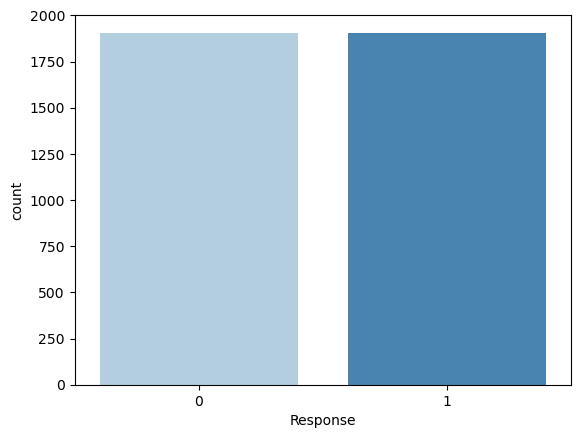

In [89]:
#balancing classes
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x, y = ros.fit_resample(x, y)
ax = sns.countplot(x=y, palette = 'Blues')

In [70]:
#defining the empty data frame to store importances
importance = pd.DataFrame(columns = store.columns).drop(columns = ['Response'])

for i in range(0, 100):

    #splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
    #building the model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(x_train, y_train)

    #extracting the feature importance
    importance.loc[i] = rf_md.feature_importances_.T

#average importance of each of the variables
pd.DataFrame({'Variable':importance.mean().index, 
              'Importance_Score':importance.mean().values}).sort_values(by = 'Importance_Score',
                                                                        ascending = False).reset_index(drop = True)

,Variable,Importance_Score
0,MntTotal,0.120371
1,MntGoldProds,0.094960
2,NumCatalogPurchases,0.087475
3,Recency,0.084583
4,MntWines,0.080263
5,Income,0.076016
6,Log_Income,0.074302
7,MntMeatProducts,0.057969
8,Child,0.042649
9,Recency_u50,0.038492


In [72]:
#Strong Heredity Principle features
store['Interaction_1'] = store['MntTotal'] * store['MntGoldProds']
store['Interaction_2'] = store['MntTotal'] * store['NumCatalogPurchases']
store['Interaction_3'] = store['MntTotal'] * store['Recency']
store['Interaction_4'] = store['MntGoldProds'] * store['NumCatalogPurchases']
store['Interaction_5'] = store['MntGoldProds'] * store['Recency']
store['Interaction_6'] = store['NumCatalogPurchases'] * store['Recency']

**Decision Tree Feature Engineering**

[Text(0.5, 0.875, 'MntTotal <= 1188.5\ngini = 0.5\nsamples = 3049\nvalue = [1524, 1525]'),
 Text(0.25, 0.625, 'Recency <= 19.5\ngini = 0.47700000000000004\nsamples = 2146\nvalue = [1304, 842]'),
 Text(0.125, 0.375, 'NumWebVisitsMonth <= 7.5\ngini = 0.467\nsamples = 610\nvalue = [227, 383]'),
 Text(0.0625, 0.125, 'gini = 0.5\nsamples = 400\nvalue = [195, 205]'),
 Text(0.1875, 0.125, 'gini = 0.258\nsamples = 210\nvalue = [32, 178]'),
 Text(0.375, 0.375, 'Enr_year <= 2012.5\ngini = 0.419\nsamples = 1536\nvalue = [1077, 459]'),
 Text(0.3125, 0.125, 'gini = 0.494\nsamples = 403\nvalue = [180, 223]'),
 Text(0.4375, 0.125, 'gini = 0.33\nsamples = 1133\nvalue = [897, 236]'),
 Text(0.75, 0.625, 'MntTotal <= 1616.0\ngini = 0.369\nsamples = 903\nvalue = [220, 683]'),
 Text(0.625, 0.375, 'Recency <= 36.0\ngini = 0.455\nsamples = 438\nvalue = [153, 285]'),
 Text(0.5625, 0.125, 'gini = 0.305\nsamples = 202\nvalue = [38, 164]'),
 Text(0.6875, 0.125, 'gini = 0.5\nsamples = 236\nvalue = [115, 121]'),
 

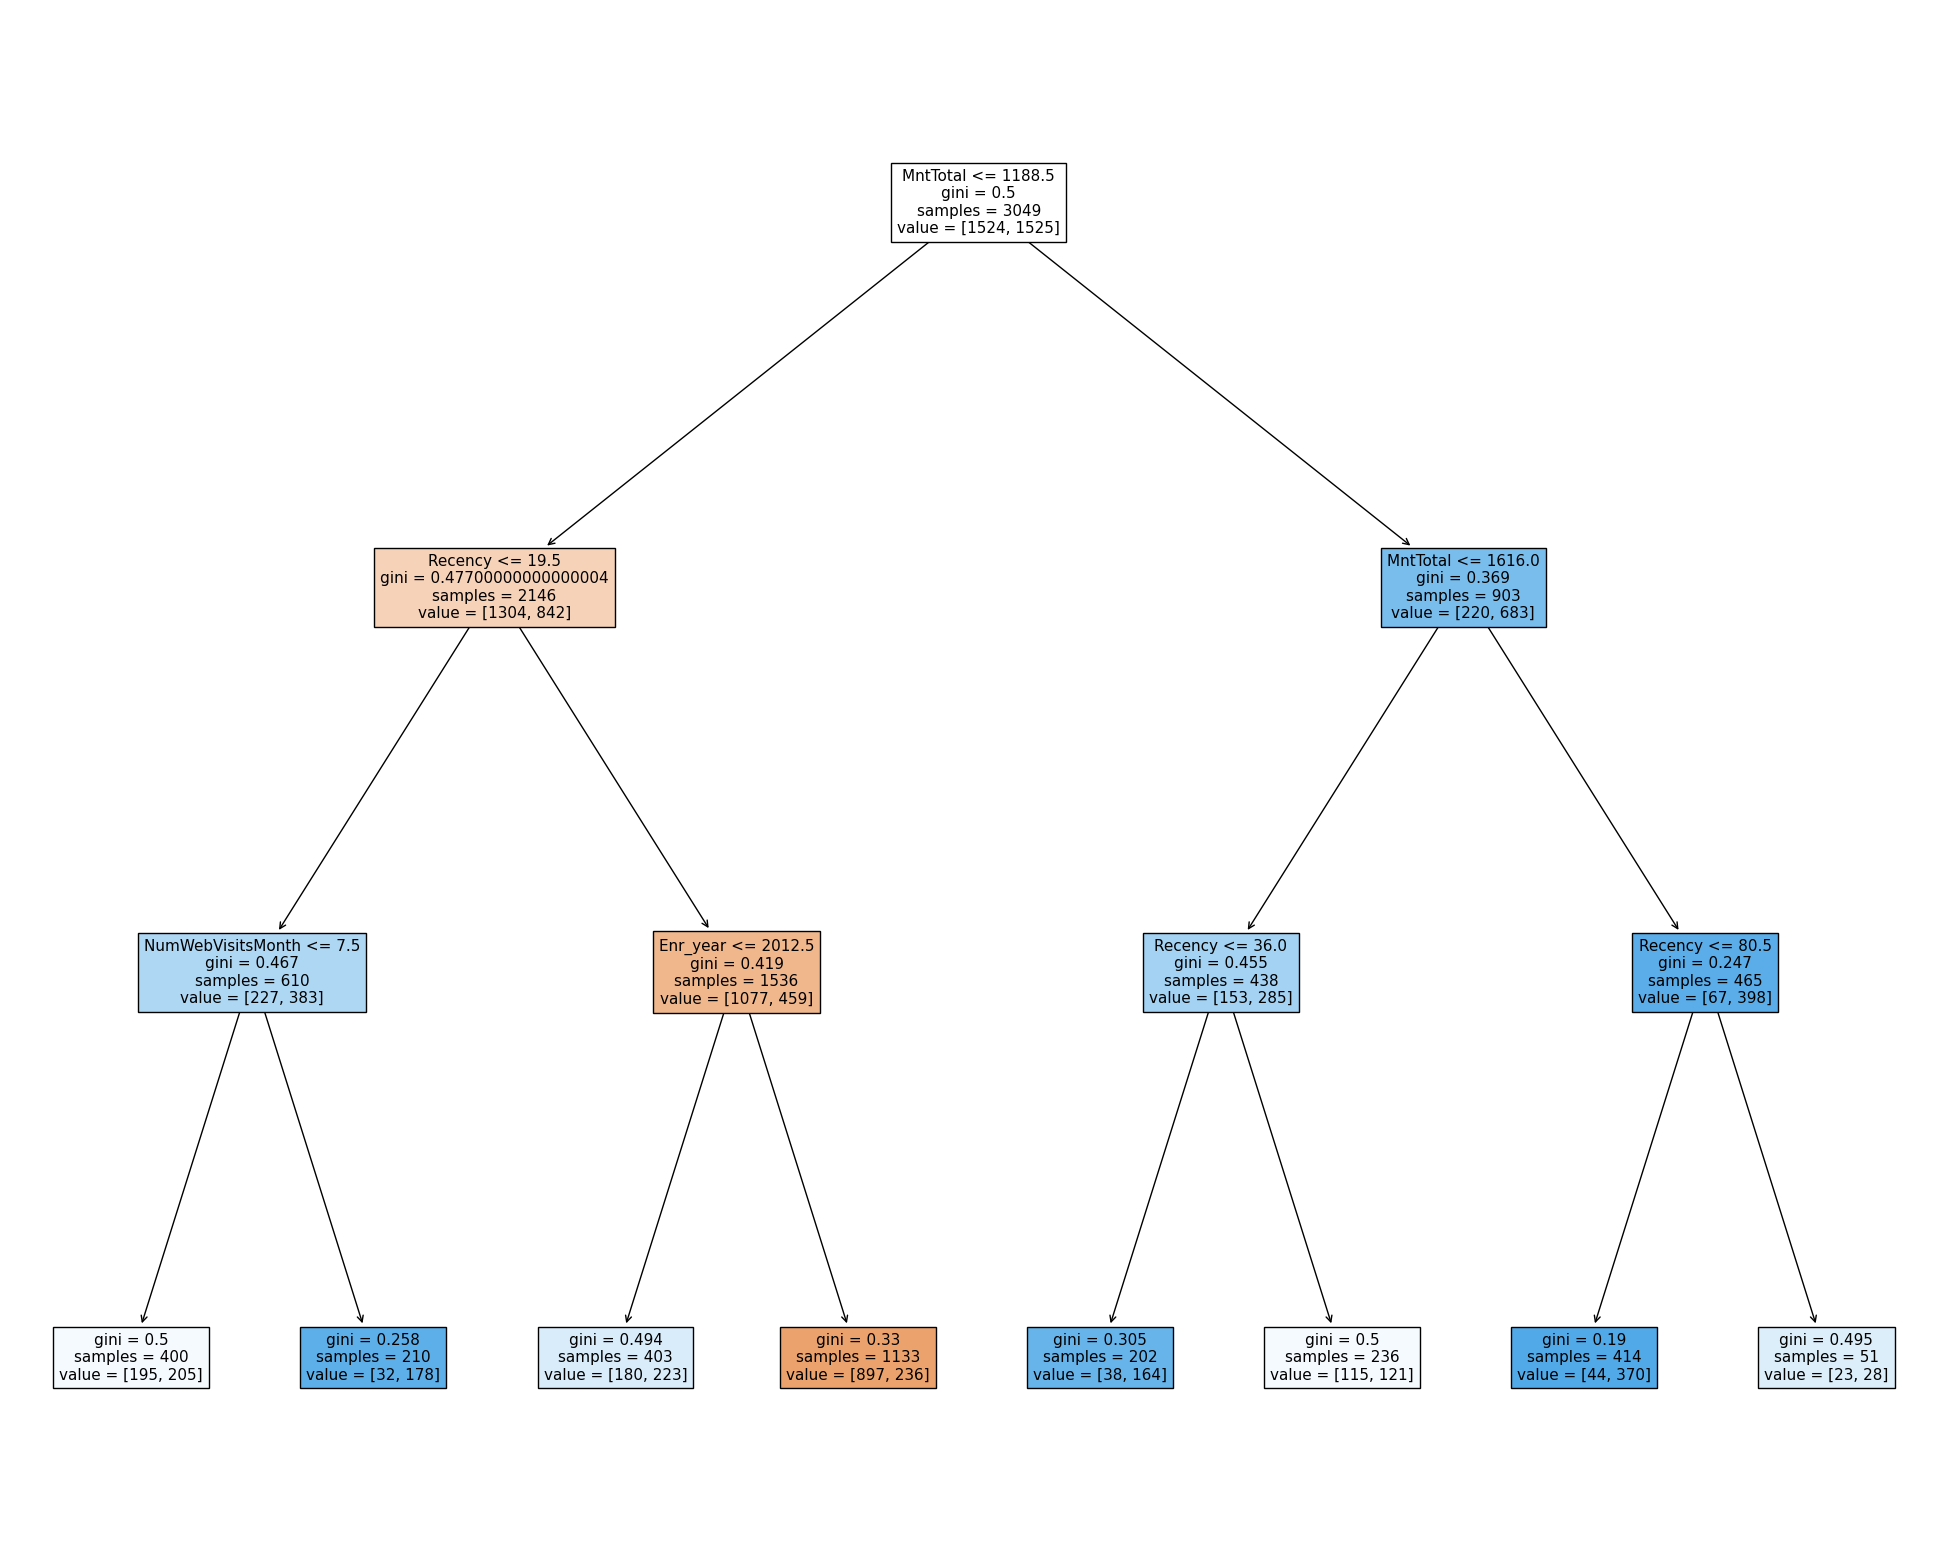

In [74]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
#building the Decision Tree model
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)
fig = plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5, 0.875, 'MntTotal <= 1176.5\ngini = 0.5\nsamples = 3049\nvalue = [1525, 1524]'),
 Text(0.25, 0.625, 'Recency <= 19.5\ngini = 0.47700000000000004\nsamples = 2137\nvalue = [1296, 841]'),
 Text(0.125, 0.375, 'NumWebVisitsMonth <= 7.5\ngini = 0.465\nsamples = 603\nvalue = [222, 381]'),
 Text(0.0625, 0.125, 'gini = 0.499\nsamples = 397\nvalue = [192, 205]'),
 Text(0.1875, 0.125, 'gini = 0.249\nsamples = 206\nvalue = [30, 176]'),
 Text(0.375, 0.375, 'Enr_year <= 2012.5\ngini = 0.42\nsamples = 1534\nvalue = [1074, 460]'),
 Text(0.3125, 0.125, 'gini = 0.495\nsamples = 411\nvalue = [185, 226]'),
 Text(0.4375, 0.125, 'gini = 0.33\nsamples = 1123\nvalue = [889, 234]'),
 Text(0.75, 0.625, 'Marital_Status_Married <= 0.5\ngini = 0.376\nsamples = 912\nvalue = [229, 683]'),
 Text(0.625, 0.375, 'Teenhome <= 0.5\ngini = 0.257\nsamples = 449\nvalue = [68, 381]'),
 Text(0.5625, 0.125, 'gini = 0.20400000000000001\nsamples = 391\nvalue = [45, 346]'),
 Text(0.6875, 0.125, 'gini = 0.4790000000000000

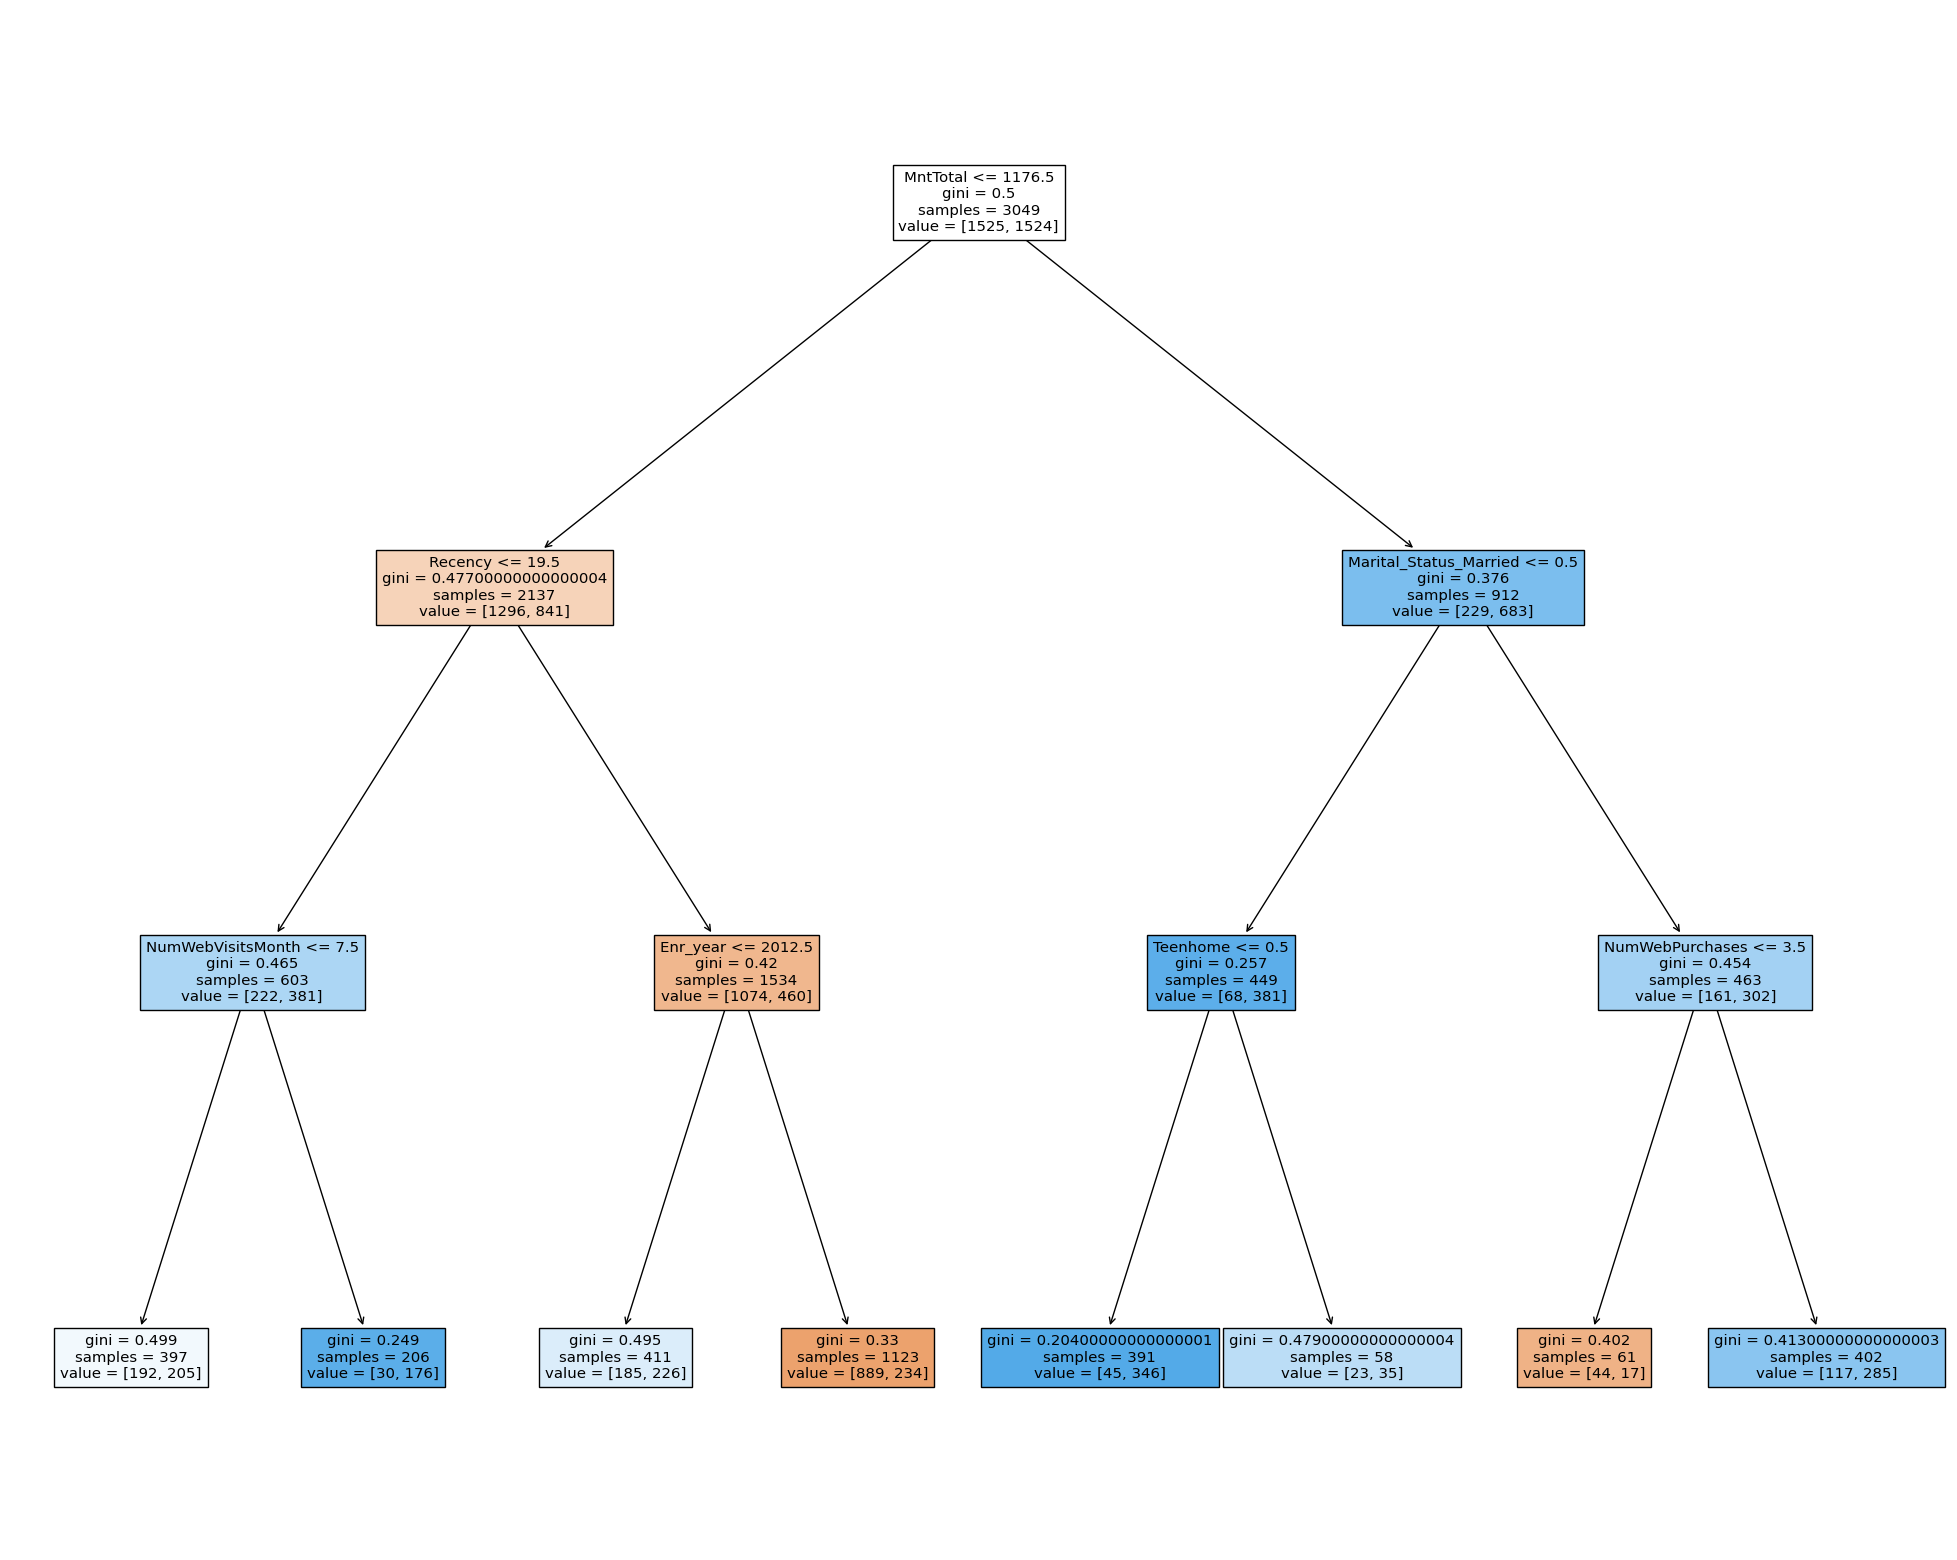

In [76]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
#building the Decision Tree model
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)
fig = plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5, 0.875, 'MntTotal <= 1188.5\ngini = 0.5\nsamples = 3049\nvalue = [1524, 1525]'),
 Text(0.25, 0.625, 'Recency <= 19.5\ngini = 0.47700000000000004\nsamples = 2138\nvalue = [1297, 841]'),
 Text(0.125, 0.375, 'NumCatalogPurchases <= 0.5\ngini = 0.47200000000000003\nsamples = 598\nvalue = [228, 370]'),
 Text(0.0625, 0.125, 'gini = 0.41100000000000003\nsamples = 135\nvalue = [96, 39]'),
 Text(0.1875, 0.125, 'gini = 0.40800000000000003\nsamples = 463\nvalue = [132, 331]'),
 Text(0.375, 0.375, 'Enr_year <= 2012.5\ngini = 0.425\nsamples = 1540\nvalue = [1069, 471]'),
 Text(0.3125, 0.125, 'gini = 0.497\nsamples = 427\nvalue = [197, 230]'),
 Text(0.4375, 0.125, 'gini = 0.339\nsamples = 1113\nvalue = [872, 241]'),
 Text(0.75, 0.625, 'Marital_Status_Married <= 0.5\ngini = 0.374\nsamples = 911\nvalue = [227, 684]'),
 Text(0.625, 0.375, 'MntWines <= 414.0\ngini = 0.262\nsamples = 457\nvalue = [71, 386]'),
 Text(0.5625, 0.125, 'gini = 0.497\nsamples = 26\nvalue = [14, 12]'),
 Text(0.6875, 0.

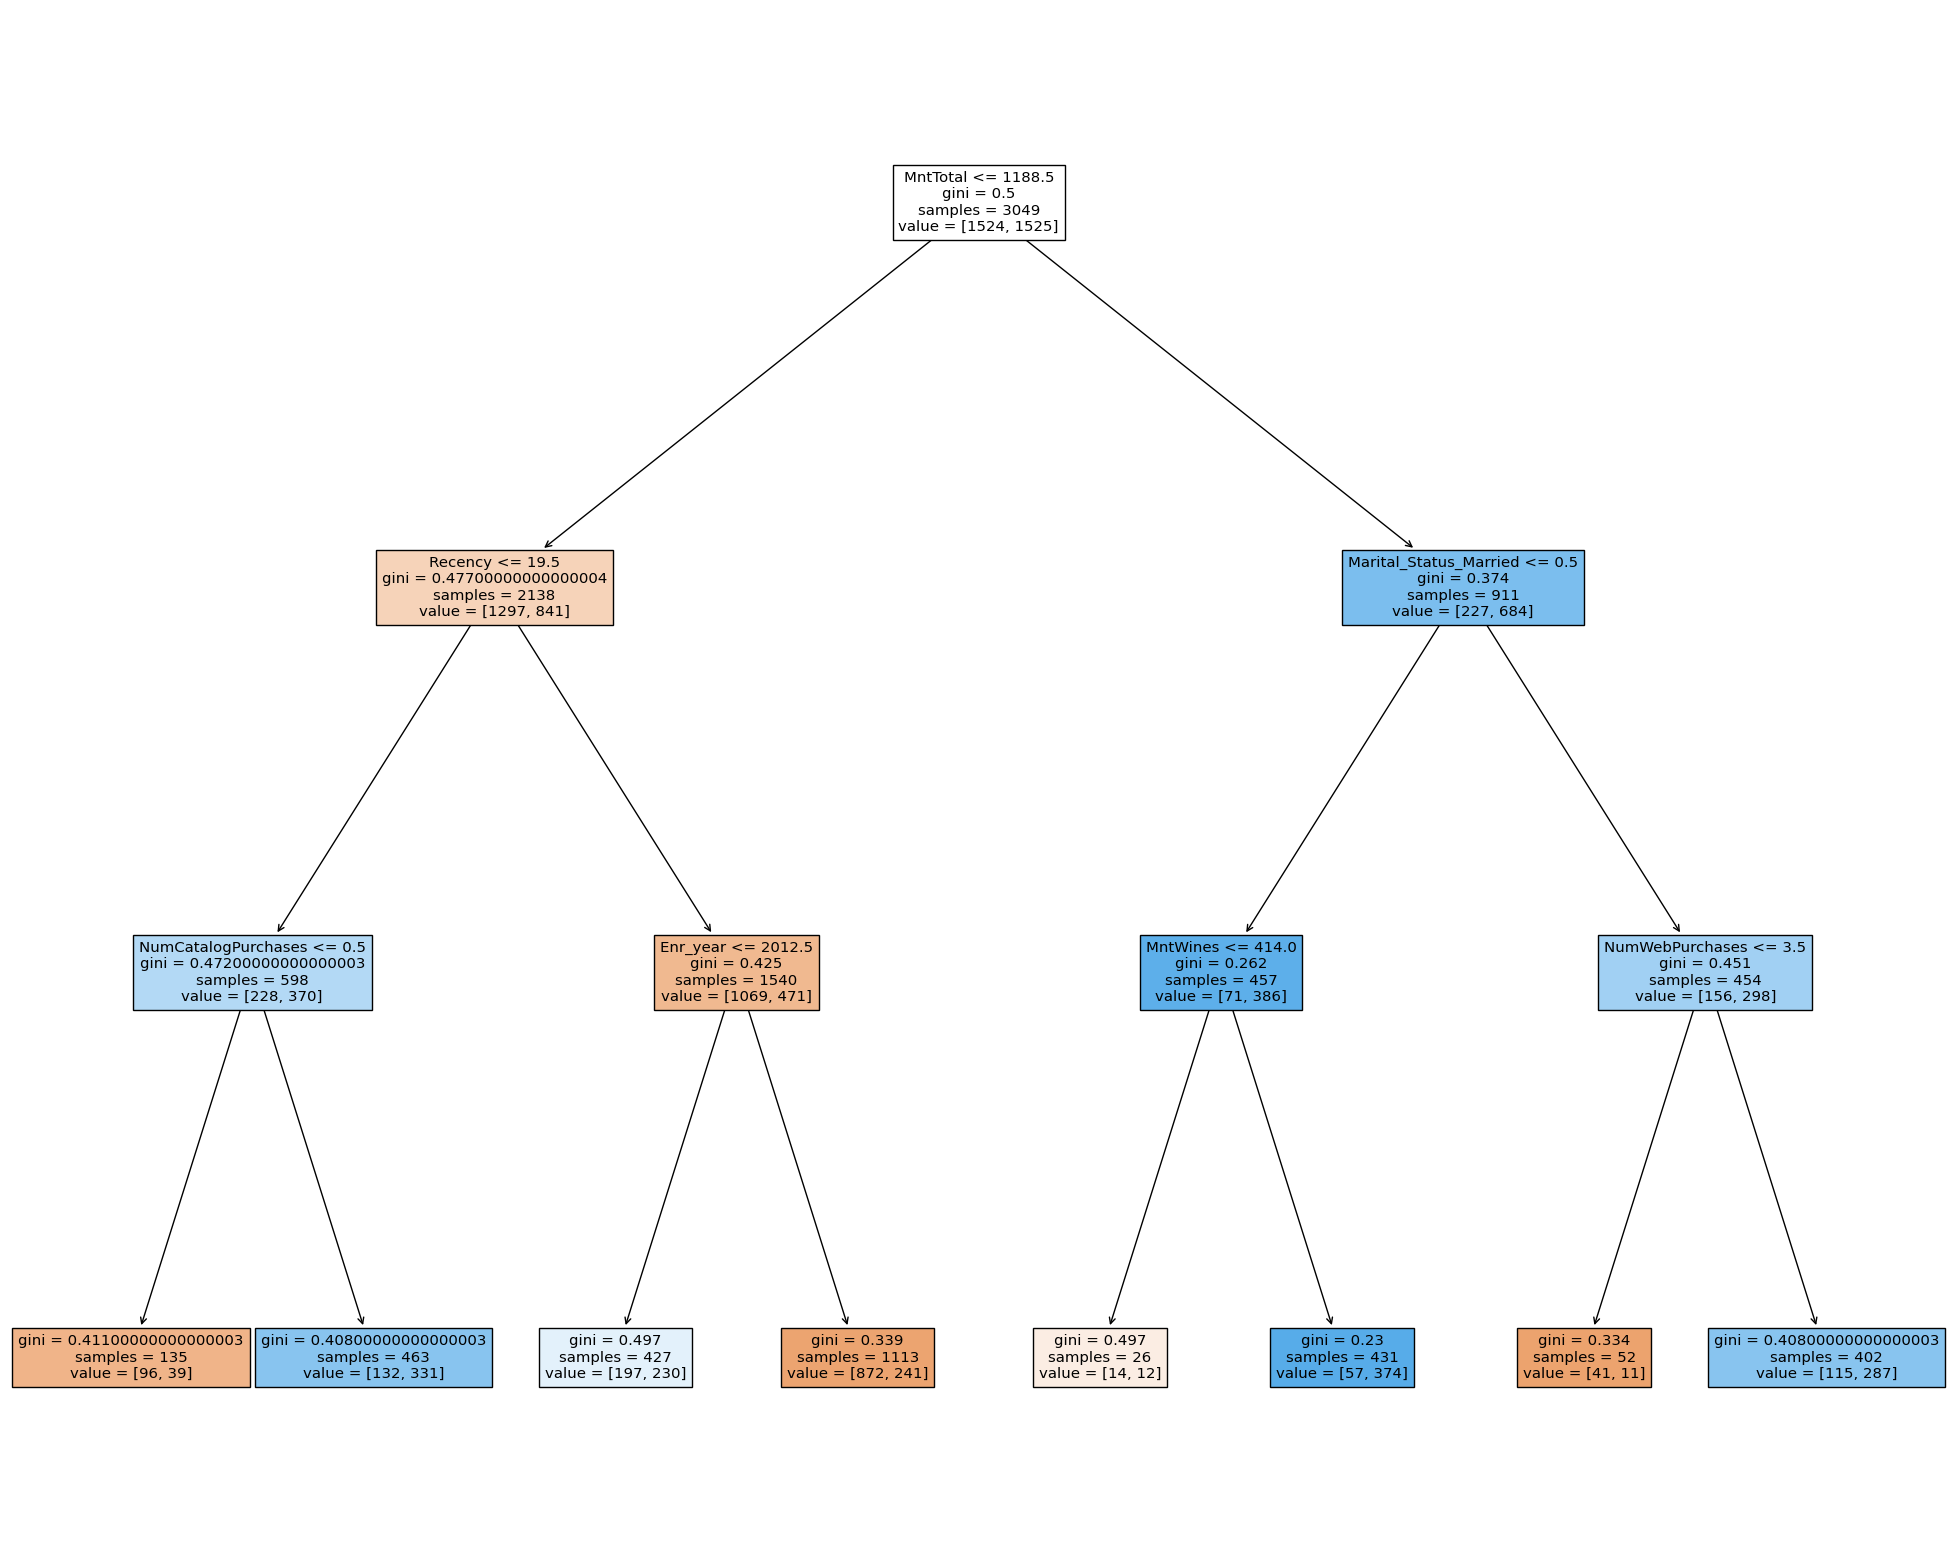

In [80]:
#splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
#building the Decision Tree model
tree_md = DecisionTreeClassifier(max_depth = 3).fit(x_train, y_train)
fig = plt.figure(figsize= (25,20))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

In [81]:
#decision tree interactions
store['Tree_1'] = np.where((store['MntTotal'] > 1188.5) & (store['Marital_Status_Married'] > 0.5) & (store['NumWebPurchases'] > 3.5), 1, 0)
store['Tree_2'] = np.where((store['MntTotal'] <= 1188.5) & (store['Recency'] <= 19.5) & (store['NumWebVisitsMonth'] <= 7.5), 1, 0)
store['Tree_3'] = np.where((store['MntTotal'] <= 1188.5) & (store['Recency'] > 19.5) & (store['Enr_year'] <= 2012.5), 1, 0)

In [91]:
store_final = horizontal_concat = pd.concat([x, y], axis=1)
store_final.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Income_imp,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow,Age,Child,MntTotal,Recency_u50,TotalPurchses,Enr_year,Enr_quarter,Enr_month,Log_Income,Interaction_1,Interaction_2,Interaction_3,Interaction_4,Interaction_5,Interaction_6,Tree_1,Tree_2,Tree_3,Response
0,1970,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,1,0,0,1,0,0,0,53,0,1190,1,14,2014,2,6,11.348463,259420,4760,0,872,0,0,0,0,0,1
1,1961,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,1,0,0,0,0,1,0,62,0,577,1,17,2014,2,6,10.952402,21349,1731,0,111,0,0,0,1,0,1
2,1958,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,1,0,0,0,1,0,0,65,1,251,1,10,2014,2,5,11.116425,7530,502,0,60,0,0,0,1,0,0
3,1967,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,1,0,0,0,1,0,0,56,1,11,1,3,2014,4,11,10.388195,0,0,0,0,0,0,0,1,0,0
4,1989,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,0,0,0,1,0,0,0,0,1,0,34,1,91,1,6,2014,3,8,9.974598,3094,91,0,34,0,0,0,1,0,1


**Final Store Data Set**

In [93]:
store_final.to_csv('store_final.csv', index = False)